## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Import data

In [2]:
data = pd.read_csv('data/Diabetes/diabetes_prediction_dataset.csv')
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


# Explore the data

## Plot data histogram

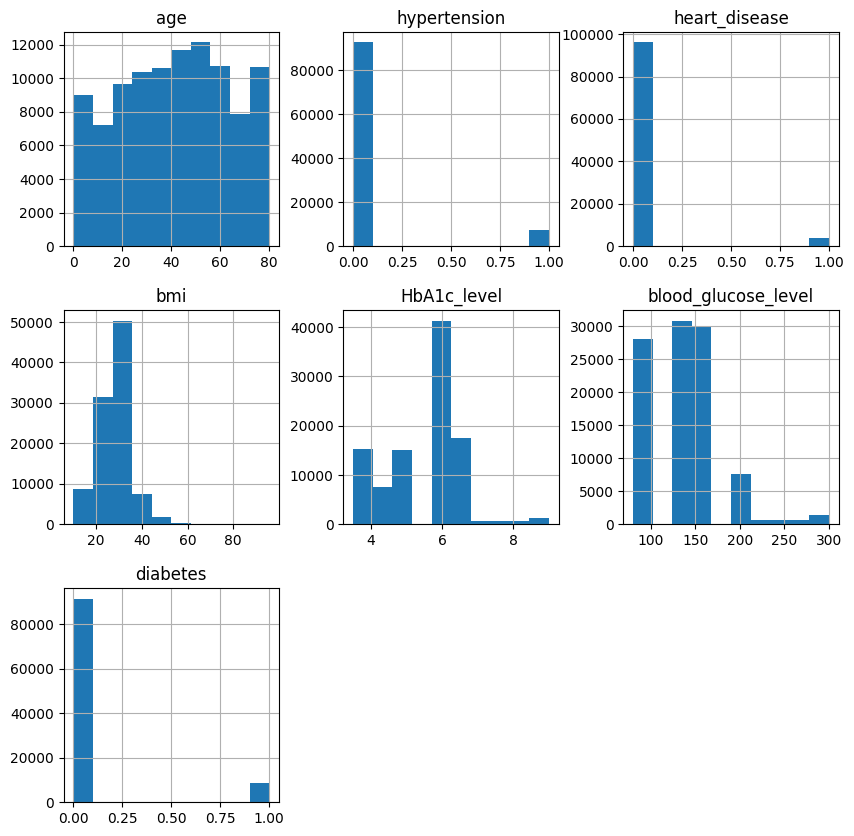

In [3]:
data.hist(figsize = (10, 10))
plt.savefig('Images/DiabetesPred/dataset_hist.png')

## Check for the categorical data and proportions

In [4]:
smoking_categories = data['smoking_history'].unique()
for smoke_cat in smoking_categories:
    print(f"{smoke_cat}: {len(data[data['smoking_history'] == smoke_cat])*100/100000}%")

never: 35.095%
No Info: 35.816%
current: 9.286%
former: 9.352%
ever: 4.004%
not current: 6.447%


In [5]:
genders = data['gender'].unique()
for gen in genders:
    print(f"{gen}: {len(data[data['gender'] == gen])*100/100000}%")

Female: 58.552%
Male: 41.43%
Other: 0.018%


## Is the target balanced?

In [6]:
len(data[data['diabetes'] == 1])*100/len(data)

8.5

We can see that only 8.5% of the targets has diabetes. We can either upsample or downsample, since we are focused on identifying persons with high probability of diabetes, we would prefer to downsample since this is the data we want to be certain about it. 

Since this is a practice notebook, we will do the analysis for 3 cases:

* Unbalanced data
* Upsampling data
* Downsampling data

But fist we want to check for the Nan and/or null data

## Check for NAN or null data

In [7]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

# Cleaning the data

### Smoking_history: 'No Info' data

In the smoking_history we have "No Info" as a value, we can count how many of this are on the dataset

In [8]:
len(data[data['smoking_history'] == 'No Info'])*100/len(data)

35.816

The amount of nan data represents around 36% of the original data, since we know that the data is unbalances, we should first check how much of the nan data are diabetic persons.

In [9]:
len(data[(data['smoking_history'] == 'No Info') & (data['diabetes'] == 1)])*100/len(data[data['diabetes'] == 1])

17.105882352941176

We can see this is around 17% of the persons with diabetes. We will then remove all the 'No Info' data in the 'smoking_history' feature since this is not an enormous amount of the dataset.

In [10]:
data = data[data['smoking_history'] != 'No Info']

### Gender: 'Other' data

'Other' data in gender can be of importance if there is enough of it, otherwise it might confuse the model or get a lower perfomance. Let's check if this is relevant in size

In [11]:
len(data[data['gender'] == 'Other'])/len(data)

0.0001869624828617724

As we can see we have almost no data for the 'Other' category in gender, we can then reduce the model to 'Female' and 'Male' data. 

In [12]:
data = data[data['gender'] != 'Other']

## Remove outliers

Let's check for outliers in the continuous data ('bmi', 'age', etc...) using 2 and 3 standard deviations as a treshold

In [13]:
columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for jj in [2, 3]:
    print(f"{jj} standard deviations")
    for col in columns:
        std = data[col].std()
        mean = data[col].mean()

        treshold = jj*std

        outliers = data[(data[col]-mean).abs() > treshold]

        print(f"# of diabetics in outliers of {col}: {len(outliers[outliers['diabetes'] == 1])}")
    print("")


2 standard deviations
# of diabetics in outliers of age: 9
# of diabetics in outliers of bmi: 839
# of diabetics in outliers of HbA1c_level: 1635
# of diabetics in outliers of blood_glucose_level: 2190

3 standard deviations
# of diabetics in outliers of age: 0
# of diabetics in outliers of bmi: 277
# of diabetics in outliers of HbA1c_level: 548
# of diabetics in outliers of blood_glucose_level: 1146



A good amount of diabetic patients are considered outliers, we will keep this data since it could be important.

## Remove nonsense data

While searching about the features I found out that a BMI lower than 11 is fatal for woman and 13 for man.
We can consider values below this outliers or even wrongly measured.

https://www.ennonline.net/fex/15/limits#:~:text=In%20males%2C%20a%20BMI%20of,low%20as%209%20and%2010.

In [14]:
data = data[((data['bmi'] >11) & (data['gender'] == 'Female')) | ((data['bmi'] >13) & (data['gender'] == 'Male'))]

# Feature Engineering

Since we have categorical data ('Smoking_history' and 'gender') we should convert the former in a binary representation (0, 1) and the latter with One Hot Encoding (OHE).

In [15]:
# Changing gender categories to 0 and 1
data.replace(to_replace = 'Male', value = 1, inplace=True)
data.replace(to_replace = 'Female', value = 0, inplace=True)

# Changing 'smoking_history' categorical data to OHE
try:
    data = pd.get_dummies(data, columns=['smoking_history'], drop_first=False, dtype = int)
except:
    print("One hot encoding has already be done")

# Reorder columns such that target is at last
new_column_order = [col for col in data.columns if col != 'diabetes'] + ['diabetes']
data = data.reindex(columns=new_column_order)

data

C:\Users\gilbe\AppData\Local\Temp\ipykernel_25416\576672929.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace(to_replace = 'Female', value = 0, inplace=True)


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,diabetes
0,0,80.0,0,1,25.19,6.6,140,0,0,0,1,0,0
2,1,28.0,0,0,27.32,5.7,158,0,0,0,1,0,0
3,0,36.0,0,0,23.45,5.0,155,1,0,0,0,0,0
4,1,76.0,1,1,20.14,4.8,155,1,0,0,0,0,0
5,0,20.0,0,0,27.32,6.6,85,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,0,26.0,0,0,34.34,6.5,160,0,0,0,1,0,0
99993,0,40.0,0,0,40.69,3.5,155,0,0,0,1,0,0
99997,1,66.0,0,0,27.83,5.7,155,0,0,1,0,0,0
99998,0,24.0,0,0,35.42,4.0,100,0,0,0,1,0,0


## Balance the data

As said before, we are going to do the 3 cases:

In [16]:
from sklearn.utils import resample

# Split data by targets
diabetic_patients = data[data['diabetes'] == 1]
non_diabetic_patients = data[data['diabetes'] == 0]

# For upsampling we must split first the data to avoid data leakage, 
# since we are doing cross-validation we do this in the pipeline in further steps

# Get down sample data
downsampling = resample(non_diabetic_patients, replace = False, n_samples=len(diabetic_patients), random_state = 628)

# Concatenate for both cases
data_down = pd.concat([diabetic_patients, downsampling])

# Feature scaling

In [17]:
# Split between features and targets for each case
columns = data.columns

X = data[columns[:-1]]
y = data[columns[-1]]

X_down = data_down[columns[:-1]]
y_down = data_down[columns[-1]]

Since the binary data represent "categorical" yes/no data we should not apply the standardization to those features.

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Features to transform
transform_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Create column transformer
ct = ColumnTransformer(transformers=[('standard_scaler', StandardScaler(), transform_features)],
    remainder='passthrough')  # Ignore other columns

#Since we will use cross validation we only need the transformer for now.

# Models

## KNN Classifier

### Unbalanced data

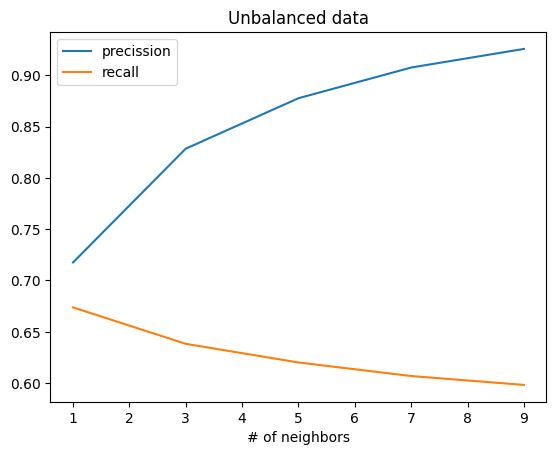

In [19]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Define a list of values for n_neighbors
neighbors_list = [1, 3, 5, 7, 9]

# Create a dictionary to store the models
knn_models = {}

y_lin_preds = []
precision_scores = []
recall_scores = []

std_scaler = StandardScaler()
ii = 0
# Create KNN classifiers for each different n_neighbors
for n in neighbors_list:
 
    knn_models[n] = KNeighborsClassifier(n_neighbors=n)
    piplin = Pipeline([('scaler', ct), ('model', knn_models[n])])

    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    cv_data = cross_validate(piplin, X, y, cv = skf, scoring = ['precision', 'recall'], return_train_score=False)
    precision_scores.append(cv_data['test_precision'].mean())
    recall_scores.append(cv_data['test_recall'].mean())

# Plot the precission and recall for each n-neighbors

plt.plot(neighbors_list, precision_scores, label = 'precission')
plt.plot(neighbors_list, recall_scores, label = 'recall')
plt.legend()
plt.xlabel('# of neighbors')
plt.title('Unbalanced data')
plt.savefig('Images/DiabetesPred/UnbalancedKNN.png')

### Upsample data

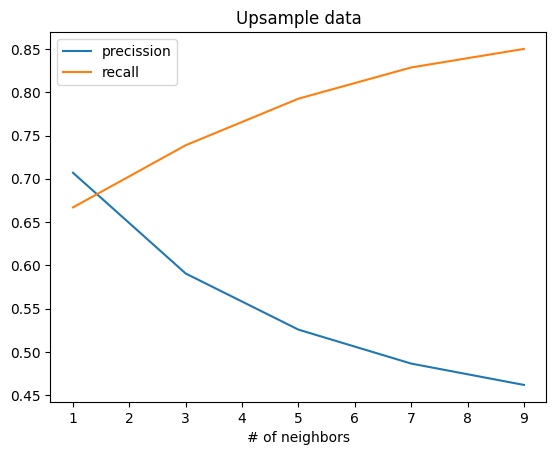

In [20]:
from imblearn.over_sampling import RandomOverSampler
# Create a dictionary to store the models
knn_models = {}

y_lin_preds = []
precision_scores = []
recall_scores = []

std_scaler = StandardScaler()
ii = 0

#Create upsampling tehcnique.
oversampler = RandomOverSampler(random_state=42)

# Create KNN classifiers for each different n_neighbors
for n in neighbors_list:
 
    knn_models[n] = KNeighborsClassifier(n_neighbors=n)
    piplin = Pipeline([('oversampling', oversampler), ('scaler', ct), ('model', knn_models[n])])

    cv_data = cross_validate(piplin, X, y, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)
    precision_scores.append(cv_data['test_precision'].mean())
    recall_scores.append(cv_data['test_recall'].mean())

# Plot the precission and recall for each n-neighbors

plt.plot(neighbors_list, precision_scores, label = 'precission')
plt.plot(neighbors_list, recall_scores, label = 'recall')
plt.legend()
plt.xlabel('# of neighbors')
plt.title('Upsample data')
plt.savefig('Images/DiabetesPred/UpSamplingKNN.png')

### Downsampled data

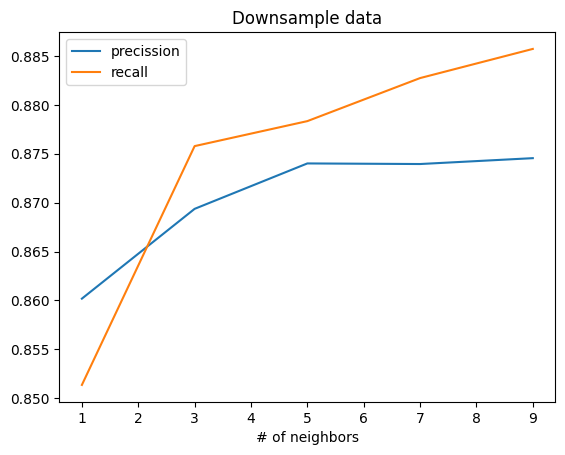

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Define a list of values for n_neighbors
neighbors_list = [1, 3, 5, 7, 9]

# Create a dictionary to store the models
knn_models = {}

y_lin_preds = []
precision_scores = []
recall_scores = []

std_scaler = StandardScaler()
ii = 0
# Create KNN classifiers for each different n_neighbors
for n in neighbors_list:
 
    knn_models[n] = KNeighborsClassifier(n_neighbors=n)
    piplin = Pipeline([('scaler', ct), ('model', knn_models[n])])

    cv_data = cross_validate(piplin, X_down, y_down, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)
    precision_scores.append(cv_data['test_precision'].mean())
    recall_scores.append(cv_data['test_recall'].mean())

# Plot the precission and recall for each n-neighbors

plt.plot(neighbors_list, precision_scores, label = 'precission')
plt.plot(neighbors_list, recall_scores, label = 'recall')
plt.legend()
plt.xlabel('# of neighbors')
plt.title('Downsample data')
plt.savefig('Images/DiabetesPred/DownsamplingKNN.png')

## SVM Models

### Unbalanced data

In [22]:
from sklearn.svm import LinearSVC

svm= LinearSVC(max_iter = 10000, dual = True)
piplinsvc = Pipeline([('scaler', ct), ('model', svm)])
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_data_svc = cross_validate(piplinsvc, X, y, cv = skf, scoring = ['precision', 'recall'], return_train_score=False)

print(f"precission: {cv_data_svc['test_precision'].mean()}, recall: {cv_data_svc['test_recall'].mean()}")

precission: 0.8885968824088593, recall: 0.6181147075525271


### Upsampled data

In [23]:
from sklearn.svm import LinearSVC

svm= LinearSVC(max_iter = 10000, dual = True)
Pipeline([('oversampling', oversampler), ('scaler', ct), ('model', knn_models[n])])

cv_data_svc = cross_validate(piplinsvc, X, y, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)

print(f"precission: {cv_data_svc['test_precision'].mean()}, recall: {cv_data_svc['test_recall'].mean()}")

precission: 0.8890894636403511, recall: 0.6179727427597956


### Downsampled data

In [24]:
from sklearn.svm import LinearSVC

svm= LinearSVC(max_iter = 10000, dual = True)
piplinsvc = Pipeline([('scaler', ct), ('model', svm)])

cv_data_svc = cross_validate(piplinsvc, X_down, y_down, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)

print(f"precission: {cv_data_svc['test_precision'].mean()}, recall: {cv_data_svc['test_recall'].mean()}")

precission: 0.8822293975569659, recall: 0.8709540034071551


## Decision tree classifier

### Unbalanced data

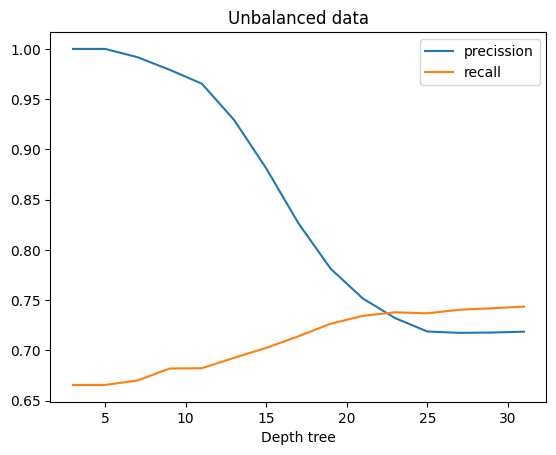

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Define a list of values for n_neighbors
depth_tree = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

# Create a dictionary to store the models
dt_models = {}

y_lin_preds_dt = []
precision_scores_dt = []
recall_scores_dt = []

ii = 0
# Create KNN classifiers for each value of n_neighbors
for n in depth_tree:
    dt_models[n] = DecisionTreeClassifier(max_depth = n)
    piplindt = Pipeline([('scaler', ct), ('model', dt_models[n])])
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    cv_data_dt = cross_validate(piplindt, X, y, cv = skf, scoring = ['precision', 'recall'], return_train_score=False)

    precision_scores_dt.append(cv_data_dt['test_precision'].mean())
    recall_scores_dt.append(cv_data_dt['test_recall'].mean())
    ii+=1

plt.plot(depth_tree, precision_scores_dt, label = 'precission')
plt.plot(depth_tree, recall_scores_dt, label = 'recall')
plt.legend()
plt.xlabel('Depth tree')
plt.title('Unbalanced data')
plt.savefig('Images/DiabetesPred/UnbalancedDT.png')

### Upsampled data

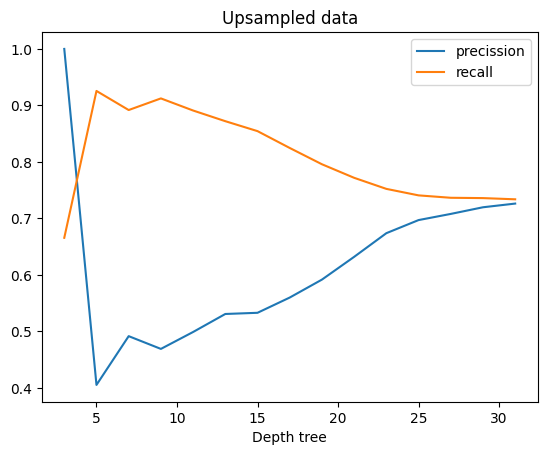

In [27]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline

# Create a dictionary to store the models
dt_models = {}

y_lin_preds_dt = []
precision_scores_dt = []
recall_scores_dt = []

ii = 0
# Create KNN classifiers for each value of n_neighbors
for n in depth_tree:
    dt_models[n] = DecisionTreeClassifier(max_depth = n)
    piplindt = Pipeline([('oversampling', oversampler), ('scaler', ct), ('model', dt_models[n])])

    cv_data_dt = cross_validate(piplindt, X, y, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)

    precision_scores_dt.append(cv_data_dt['test_precision'].mean())
    recall_scores_dt.append(cv_data_dt['test_recall'].mean())
    ii+=1

plt.plot(depth_tree, precision_scores_dt, label = 'precission')
plt.plot(depth_tree, recall_scores_dt, label = 'recall')
plt.legend()
plt.xlabel('Depth tree')
plt.title('Upsampled data')
plt.savefig('Images/DiabetesPred/UpsamplingDT.png')

### Downsampled data

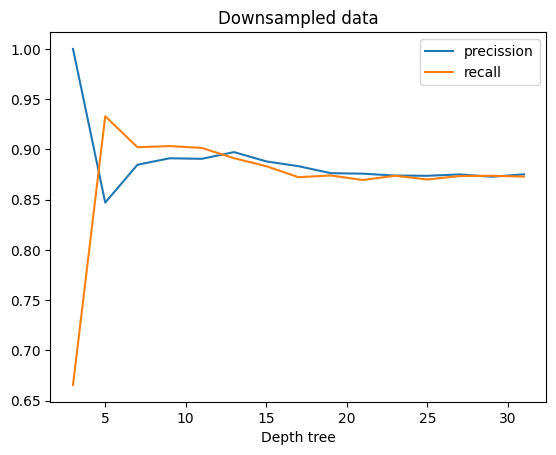

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Create a dictionary to store the models
dt_models = {}

y_lin_preds_dt = []
precision_scores_dt = []
recall_scores_dt = []

ii = 0
# Create KNN classifiers for each value of n_neighbors
for n in depth_tree:
    dt_models[n] = DecisionTreeClassifier(max_depth = n)
    piplindt = Pipeline([('scaler', ct), ('model', dt_models[n])])

    cv_data_dt = cross_validate(piplindt, X_down, y_down, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)

    precision_scores_dt.append(cv_data_dt['test_precision'].mean())
    recall_scores_dt.append(cv_data_dt['test_recall'].mean())
    ii+=1

plt.plot(depth_tree, precision_scores_dt, label = 'precission')
plt.plot(depth_tree, recall_scores_dt, label = 'recall')
plt.legend()
plt.xlabel('Depth tree')
plt.title('Downsampled data')
plt.savefig('Images/DiabetesPred/DownsamplingDT.png')

## Logistic Regression

### Unbalanced data

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
piplinlr = Pipeline([('scaler', std_scaler), ('model', lr)])
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_data_lr = cross_validate(piplinlr, X, y, cv = skf, scoring = ['precision', 'recall'], return_train_score=False)

print(f"precission: {cv_data_lr['test_precision'].mean()}, recall: {cv_data_lr['test_recall'].mean()}")

precission: 0.8603960072760447, recall: 0.6386602036429359


### Upsampled data

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
piplinlr = Pipeline([('oversampling', oversampler), ('scaler', ct), ('model', knn_models[n])])

cv_data_lr = cross_validate(piplinlr, X, y, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)

print(f"precission: {cv_data_lr['test_precision'].mean()}, recall: {cv_data_lr['test_recall'].mean()}")

precission: 0.880458002799076, recall: 0.8682036585166509


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
piplinlr = Pipeline([('scaler', std_scaler), ('model', lr)])

cv_data_lr = cross_validate(piplinlr, X_down, y_down, cv = 4, scoring = ['precision', 'recall'], return_train_score=False)

print(f"precission: {cv_data_lr['test_precision'].mean()}, recall: {cv_data_lr['test_recall'].mean()}")

precission: 0.8786246110561895, recall: 0.8675853609644195


# Figures for report

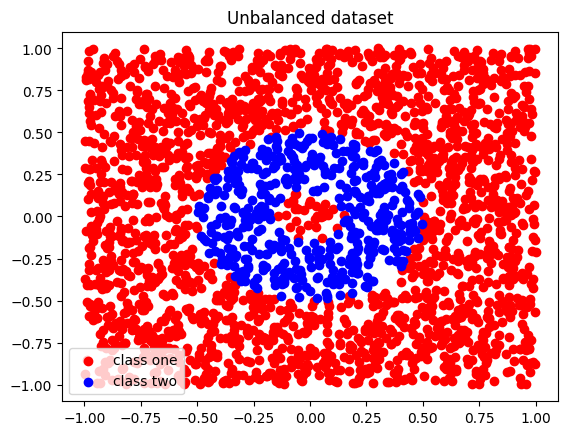

In [58]:
import numpy as np

x1 = []
y1 = []

x2 = []
y2 = []
for ii in range(2500):
    x = 2*np.random.random()-1
    y = 2*np.random.random()-1

    if np.sqrt(x**2 + y**2) > 0.5 or np.sqrt(x**2 + y**2) < 0.15:
        x1.append(x)
        y1.append(y)
    else:
        x2.append(x)
        y2.append(y)

plt.scatter(x1, y1, c = 'r', label = 'class one')
plt.scatter(x2, y2, c = 'b', label = 'class two')
plt.legend()
plt.title('Unbalanced dataset')
plt.savefig('Images/DiabetesPred/Unbalance-demo.png')

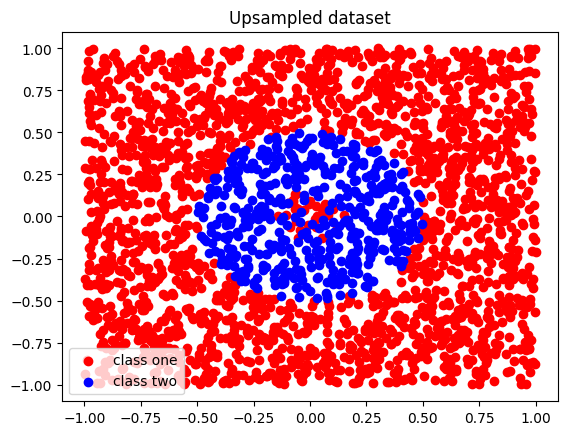

In [59]:
for ii in range(30):
    x = 0.3*np.random.random()-0.15
    y = 0.3*np.random.random()-0.15

    if np.sqrt(x**2 + y**2) < 0.15:
        x2.append(x)
        y2.append(y)

plt.scatter(x1, y1, c = 'r', label = 'class one')
plt.scatter(x2, y2, c = 'b', label = 'class two')
plt.legend()
plt.title('Upsampled dataset')
plt.savefig('Images/DiabetesPred/Upsampled-demo.png')